In [1]:
%load_ext autotime

## Build Reference PSC

In [2]:
import os
import numpy as np
import pandas as pd
from copy import copy

from glob import glob

from matplotlib import pyplot as plt
plt.style.use('bmh')
from IPython import display

from astropy.time import Time
from astropy.stats import sigma_clip

from piaa.exoplanets import TransitInfo, get_exoplanet_transit
from piaa.utils import helpers
from piaa.utils import plot
from piaa.utils import pipeline

time: 3.43 s


In [3]:
fields_dir = os.path.join(os.environ['PANDIR'], 'images', 'fields')

time: 732 µs


In [4]:
# unit_id = 'PAN001'
# field_id = 'Wasp50'
# cam_id = '14d3bd'
# seq_id = '20181215T050712'
# seq_id = '20180913T085704'
unit_id = 'PAN012'
field_id = 'Hd189733'
cam_id = '358d0f'
seq_id = '20180822T035809'

sequence = '_'.join([unit_id, cam_id, seq_id])
sequence

'PAN012_358d0f_20180822T035809'

time: 5.61 ms


In [5]:
base_dir = os.path.join(fields_dir, unit_id, field_id, cam_id, seq_id)

base_dir

'/var/panoptes/images/fields/PAN012/Hd189733/358d0f/20180822T035809'

time: 2.56 ms


In [6]:
ticid = 256364928  # HD 189733
# ticid = 11036706
# ticid = 11133818  # Ugly PSF
# ticid = 388448267 # Ugly PSF

# ticid = 417898196
# ticid = 382391899  # Wasp 50
# ticid = 11027938
# ticid = 11133818
# ticid = 452180117

time: 603 µs


In [7]:
stamp_book_size = 200

time: 626 µs


In [8]:
# Get the list of similar stars. The picid at index 0 is the target star
collection_fn = os.path.join(base_dir, 'stamps', 'similar', f'{ticid}.csv')
vary_list = pd.read_csv(collection_fn, names=['picid', 'v'])

time: 28.2 ms


In [9]:
vary_list.head()

,picid,v
0,256364928,0.000000
1,288050805,0.025052
2,396019766,0.053982
3,299915077,0.065076
4,280451126,0.065363


time: 11.4 ms


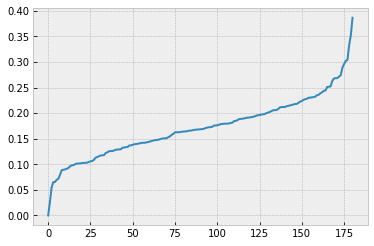

time: 250 ms


In [10]:
plt.plot(vary_list.iloc[:stamp_book_size].v)

### Get stamp collection

Build up a stamp book of the target star and the top references.

In [11]:
stamp_files = glob(os.path.join(base_dir, 'stamps', '*.csv'))

time: 2.82 ms


In [12]:
ref_list = list(vary_list.picid[:stamp_book_size].values)

time: 1.17 ms


In [13]:
camera_bias = 2048

time: 549 µs


In [14]:
# Slice frames
# Empirically based
frame_slice = slice(0, -1)

time: 616 µs


In [15]:
filter_time = '2018-08-22 07:15:00'

time: 574 µs


In [16]:
stamp_collection = list()

for i, picid in enumerate(ref_list):
    stamp_fn = os.path.join(base_dir, 'stamps', f'{picid}.csv')
    
    try:
        full_ref_table = pd.read_csv(stamp_fn).set_index(['obs_time', 'picid'])
    except FileNotFoundError:
        continue
        
#     ref_table = full_ref_table.query(f"obs_time <= '{filter_time}'")
    ref_table = full_ref_table

    ref_psc = np.array(ref_table) - camera_bias
    stamp_collection.append(ref_psc)
    
stamp_collection = np.array(stamp_collection)

stamp_collection = stamp_collection[:, frame_slice, :]
image_times = pd.to_datetime(ref_table.index.levels[0].values)[frame_slice]

stamp_collection.shape

(181, 124, 100)

time: 1.81 s


In [17]:
# Get target PSC (may have changed with frame_slice)
target_psc = stamp_collection[0]

num_frames = stamp_collection.shape[1]
num_frames

124

time: 3.23 ms


In [42]:
num_refs = 30

time: 575 µs


In [43]:
# Get a normalized version of the entire stamp collection
normalized_collection = np.array([pipeline.normalize(s) for s in stamp_collection[:num_refs]])
normalized_collection.shape

(30, 124, 100)

time: 7.49 ms


### Build coeffecients

In [44]:
# Get the coefficients the most optimally combine the normalized referenes into 
# one single master reference.
coeffs = pipeline.get_ideal_full_coeffs(normalized_collection)

time: 7.56 ms


Text(0.5, 1.0, 'Reference coeffecients - 256364928')

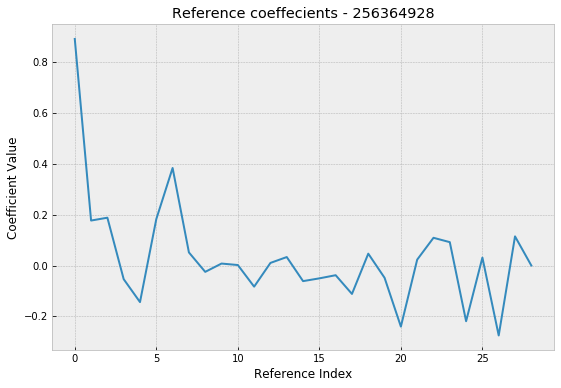

time: 297 ms


In [45]:
plt.figure(figsize=(9, 6))
plt.plot(coeffs[0])
plt.xlabel('Reference Index')
plt.ylabel('Coefficient Value')
plt.title(f'Reference coeffecients - {ticid}')

### Build reference PSC

In [46]:
# Use the coeffecients generated from the normalized references and
# apply them to the non-normalized (i.e. flux) stamps
ideal_psc = pipeline.get_ideal_full_psc(
    stamp_collection[:num_refs], 
    coeffs[0]
).reshape(num_frames, -1)
ideal_psc.shape

(124, 100)

time: 5.13 ms


4 4 G2


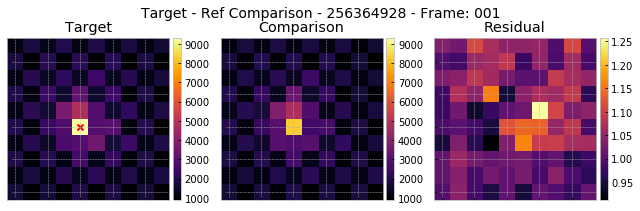

time: 776 ms


In [47]:
stamp_side = int(np.sqrt(target_psc.shape[1]))

frame_idx = 1

# Reshape into square stamps and plot the requested frame
stamp_fig = plot.show_stamps([
    target_psc.reshape(num_frames, stamp_side, stamp_side), 
    ideal_psc.reshape(num_frames, stamp_side, stamp_side)
], frame_idx=frame_idx, show_residual=True, stretch='linear')

stamp_fig.set_size_inches(9, 3.1)

stamp_fig.suptitle(f'Target - Ref Comparison - {ticid} - Frame: {frame_idx:03d}', 
                   y=1.0, fontsize=14)

# Mask the brightest pixel
t0 = target_psc[frame_idx].reshape(stamp_side, stamp_side)
y_pos, x_pos = np.argwhere(t0 == t0.max())[0]
center_color = helpers.pixel_color(x_pos, y_pos)
print(x_pos, y_pos, center_color)
stamp_fig.axes[0].scatter(x_pos, y_pos, marker='x', color='r')

stamp_fig.tight_layout()
target_ref_comp_fn = os.path.join(base_dir, f'ref-comparison-{ticid}-{frame_idx:03d}.png')
stamp_fig.savefig(target_ref_comp_fn, transparent=False)

display.display(stamp_fig)

### Aperture photometry

In [48]:
aperture_size = 5

time: 550 µs


In [49]:
lc0 = pipeline.get_aperture_sums(
    target_psc, 
    ideal_psc, 
    image_times,
    aperture_size=aperture_size, 
#     plot_apertures=True,
    aperture_fn=os.path.join(base_dir, 'apertures', f'{ticid}')
)

time: 181 ms


In [50]:
# Save the lightcurve dataframe to a csv file
# NOTE: We do this before normalizing
csv_file = os.path.join(base_dir, '{}_{}_lc.csv'.format(
    sequence.replace('/', '_'), 
    ticid
))

# Save before adding relative flux
lc0.to_csv(csv_file)

time: 94.4 ms


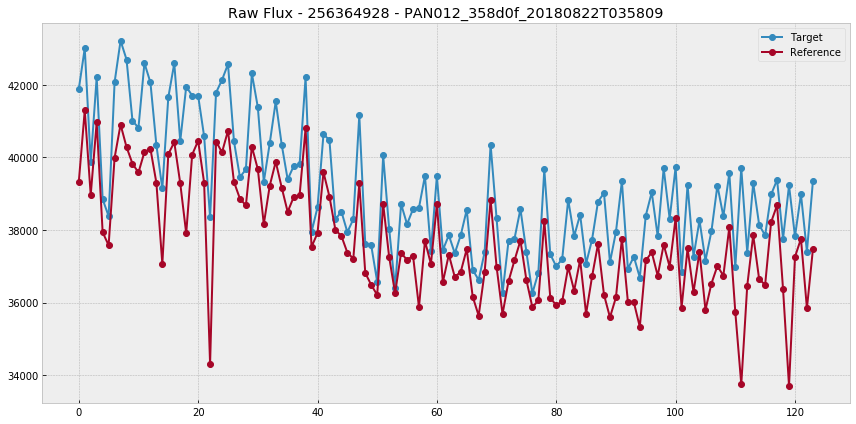

time: 563 ms


In [51]:
plt.figure(figsize=(12, 6))
plt.plot(lc0.loc[lc0.color == 'g'].target.values, marker='o', label='Target') #.plot(marker='o')
plt.plot(lc0.loc[lc0.color == 'g'].reference.values, marker='o', label='Reference') #.plot(marker='o')
plt.title(f'Raw Flux - {ticid} - {sequence}')
plt.tight_layout()
plt.legend()

plot_fn = os.path.join(base_dir, f'raw-flux-{ticid}-{sequence}.png')
plt.savefig(plot_fn)

In [70]:
# Make a copy
lc1 = lc0.copy()

time: 1.14 ms


In [71]:
for field in ['reference', 'target']:
#     color_normer = lc0[:30].groupby('color')[field].apply(lambda x: np.mean(x))
    color_normer = lc1.groupby('color')[field].apply(lambda x: np.median(x))

    for color, normalizer in color_normer.iteritems():
        print(f"{field} {color} μ={normalizer:.04f}")

        # Get the raw values
        raw_values = lc1.loc[lc1.color == color, (field)]

        lc1.loc[lc1.color == color, (f'{field}')] = (raw_values / normalizer)

reference b μ=10921.1750
reference g μ=37435.1540
reference r μ=11976.1939
target b μ=11639.5000
target g μ=38751.5000
target r μ=12263.0000
time: 33.6 ms


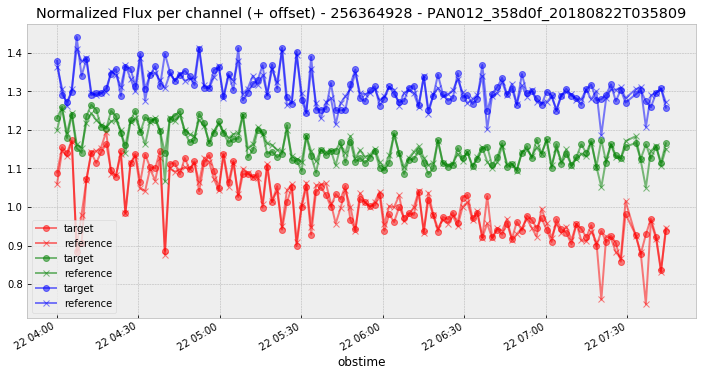

time: 730 ms


In [72]:
plt.figure(figsize=(12, 6))
i = 0
for color in 'rgb':
    (lc1.loc[lc1.color == color].target + i).plot(marker='o', color=color, alpha=0.5)
    (lc1.loc[lc1.color == color].reference + i).plot(marker='x', color=color, alpha=0.5)
    i += .15

plt.title(f'Normalized Flux per channel (+ offset) - {ticid} - {sequence}')
plt.legend()

plot_fn = os.path.join(base_dir, f'normalized-flux-{ticid}-{sequence}.png')
plt.savefig(plot_fn)

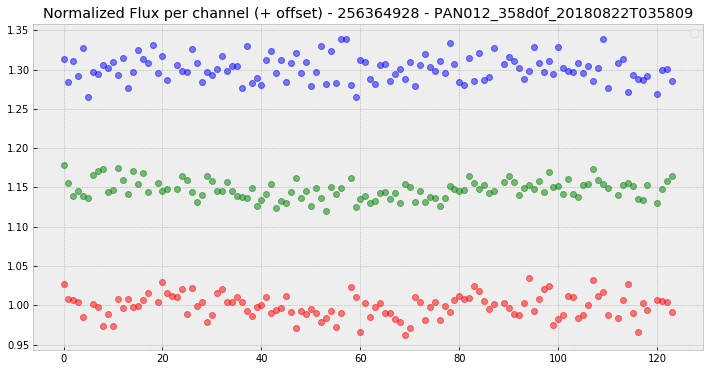

time: 508 ms


In [73]:
plt.figure(figsize=(12, 6))
i = 0

for color in 'rgb':
    for lc_table, marker in zip([lc1], 'ox'):    
        t0 = lc_table.loc[lc_table.color == color].target
        r0 = lc_table.loc[lc_table.color == color].reference
        
        f0 = sigma_clip(t0 / r0, sigma=3)
        
        plt.plot((f0 + i), marker=marker, ls='', alpha=0.5, color=color)
        i += .15

# plt.ylim([.9, 1.1])

plt.title(f'Normalized Flux per channel (+ offset) - {ticid} - {sequence}')
plt.legend()

plot_fn = os.path.join(base_dir, f'normalized-flux-{ticid}-{sequence}.png')
plt.savefig(plot_fn)

### Exoplanet info

See bottom of notebook

In [74]:
transit_times = TransitInfo(
    Time('2018-08-22 04:53:00'),
    Time('2018-08-22 05:47:00'),
    Time('2018-08-22 06:41:00')
)

# transit_times = TransitInfo(
#     Time('2018-09-13 09:21:00'),
#     Time('2018-09-13 10:15:00'),
#     Time('2018-09-13 11:09:00')
# )

transit_datetimes = [transit_times.midpoint.datetime, transit_times.ingress.datetime, transit_times.egress.datetime]

time: 2.32 ms


σ=1.9683%


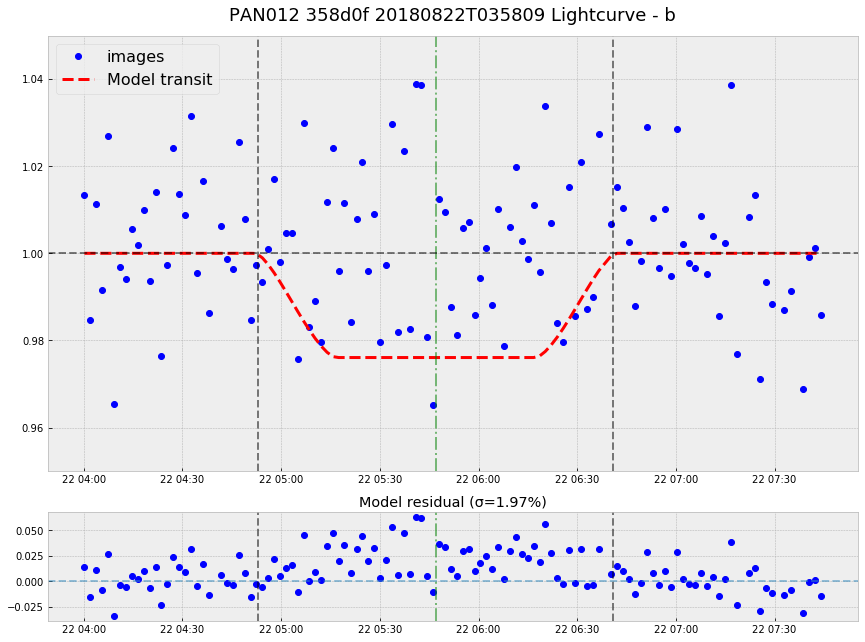

σ=1.1830%


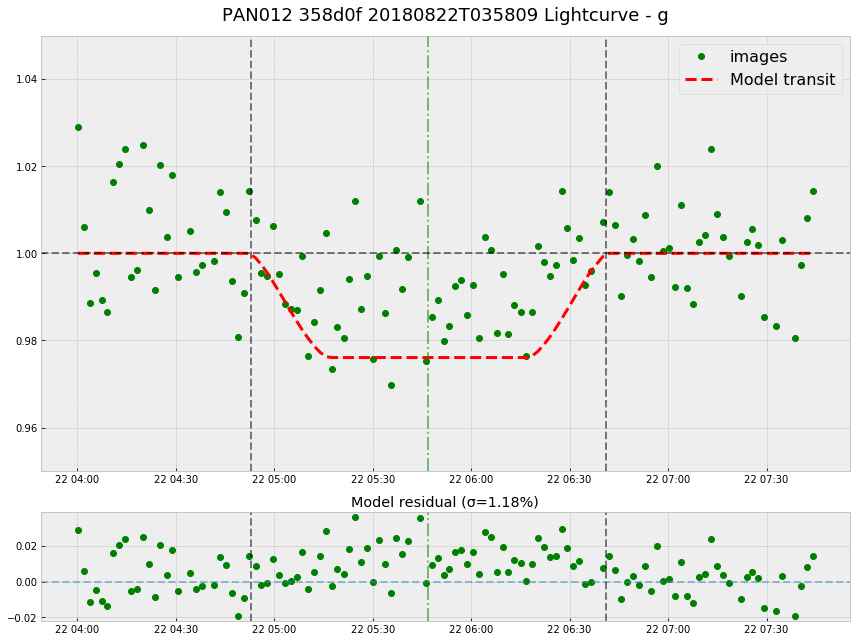

σ=1.5878%


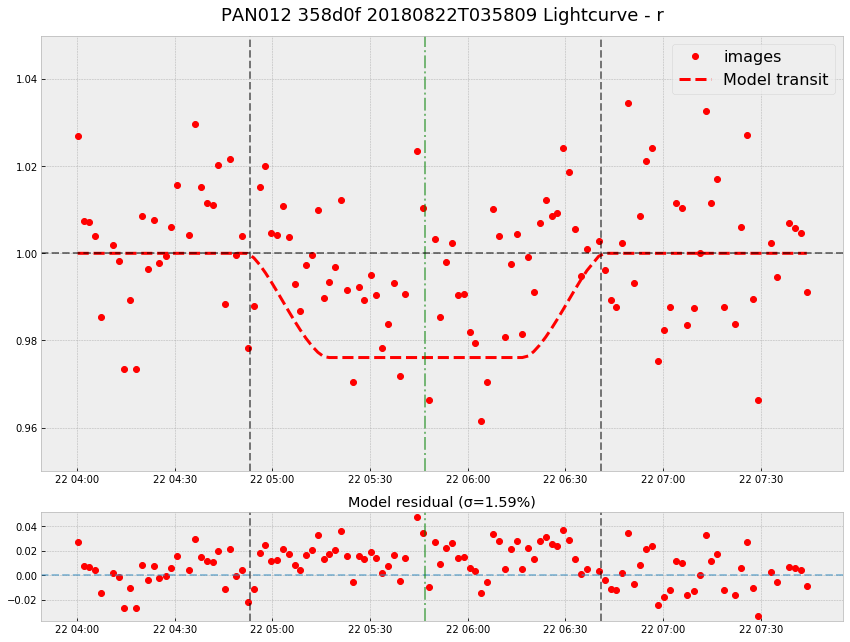

time: 2.29 s


In [94]:
for color, data in lc1.groupby('color'):
    
    y = pd.Series(sigma_clip(data.target / data.reference), index=lc1.index.unique()).dropna()
    x = y.index
    
#     base_model_flux = np.ones_like(y)
    base_model_flux = get_exoplanet_transit(x, transit_times=transit_times)
    
    lc_fig = plot.plot_lightcurve(x, y, base_model_flux, 
        transit_info=transit_datetimes,
        title="{} Lightcurve - {}".format(sequence.replace('_', ' '), color),
        ylim=[.9, 1.1], 
        color=color
    )    
    lc_fig.get_axes()[0].set_ylim([0.95, 1.05])
       
    print('σ={:.04%}'.format((y - base_model_flux).std()))
       
    display.display(lc_fig)

### Examine

In [59]:
# Detrend by the median value
t0 = target_psc.sum(1) / np.mean(target_psc.sum(1))
i0 = ideal_psc.sum(1) / np.mean(ideal_psc.sum(1))

time: 2.07 ms


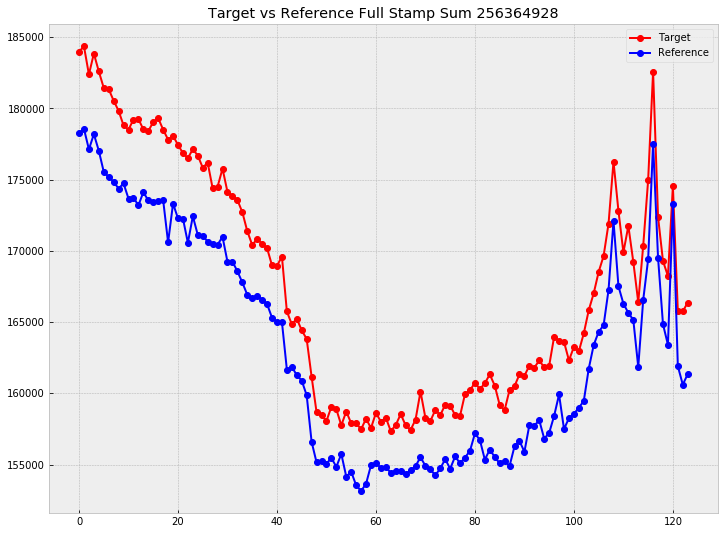

time: 449 ms


In [60]:
plt.figure(figsize=(12, 9))
plt.plot(target_psc.sum(1), marker='o', c='r', label='Target')
plt.plot(ideal_psc.sum(1), marker='o', c='b', label='Reference')

# plt.axvline(midpoint, label='mid-transit', ls='-.', c='g')
# plt.axvline(ingress, label='ingress', ls='--')
# plt.axvline(egress, label='egress', ls='--')

plt.title(f'Target vs Reference Full Stamp Sum {ticid}')
plt.legend()

### Exoplanet info

HD 189733 b
```
a........... 8.83602
ecc......... 0.0
fp.......... None
inc......... 85.71
limb_dark... uniform
per......... 2.21857567
rp.......... 0.15468774550850156
t0.......... 0.0
t_secondary. None
u........... []
w........... 90.0
```